# Distributed Angle & Distance Tracking with Extended Kalman Filter

This notebook demonstrates target tracking using a network of sensor nodes. Each node measures either:
- **Distance** to the target (type-0 nodes)
- **Angle** to the target (type-1 nodes)

We implement:
- **Centralized Extended Kalman Filter (CEKF)** - performance upper bound
- **Diffusion Extended Kalman Filter (DEKF)** - distributed baseline

## Imports

In [153]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.func import jacrev

# Import Kalman filter functions (now support arbitrary state dimensions)
from utils.ClassicDistributedKalman import (
    centralized_extended_kalman_filter,
    diffusion_extended_kalman_filter,
    diffusion_extended_kalman_filter_parallel_edge
)

torch.set_default_dtype(torch.float)

## 1. System Models

### State Space Model
The target follows a constant velocity model with state vector $\mathbf{x} = [x, v_x, y, v_y]^T$:

$$\mathbf{x}_{k+1} = \mathbf{F} \mathbf{x}_k + \mathbf{w}_k$$

### Observation Models
- **Distance nodes** (type-0): $h_i(\mathbf{x}) = \sqrt{(x - x_i)^2 + (y - y_i)^2}$
- **Angle nodes** (type-1): $h_i(\mathbf{x}) = \arctan2(y - y_i, x - x_i)$

In [154]:
class ConstantVelocityModel:
    """
    Linear state evolution for constant velocity target tracking.
    State: [x, vx, y, vy]^T (position and velocity in 2D)
    
    Compatible with ClassicDistributedKalman.py interface:
    - __call__(x): returns next state
    - jacobian(x): returns Jacobian matrix
    """
    def __init__(self, time_delta: float):
        self.dt = time_delta
        self.state_dimension = 4
        # F matrix for constant velocity model
        self.state_transition_matrix = torch.tensor(
            [[1, self.dt, 0,       0], 
             [0,       1, 0,       0], 
             [0,       0, 1, self.dt], 
             [0,       0, 0,       1]], dtype=torch.float)

    def __call__(self, x):
        """Apply state evolution: x_{k+1} = F * x_k"""
        if isinstance(x, np.ndarray):
            return (self.state_transition_matrix @ torch.tensor(x, dtype=torch.float)).numpy()
        return self.state_transition_matrix @ x
    
    def jacobian(self, x):
        """
        For linear system, Jacobian F is constant.
        
        Args:
            x: State array, shape (N, state_dim) or (state_dim,)
        Returns:
            Jacobians, shape (N, state_dim, state_dim)
        """
        F = self.state_transition_matrix.numpy()
        if x is None:
            return F[np.newaxis, ...]
        # Determine batch size from input
        if x.ndim == 1:
            batch_size = 1
        else:
            batch_size = x.shape[0]
        return np.tile(F[np.newaxis, ...], (batch_size, 1, 1))

In [155]:
class DistanceAngleObservation:
    """
    Nonlinear observation function using distance/angle measurements.
    
    Type-0 (angle): h(x) = atan2(y - y_i, x - x_i)
    Type-1 (distance): h(x) = sqrt((x - x_i)^2 + (y - y_i)^2)
    
    Compatible with ClassicDistributedKalman.py interface:
    - __call__(x, n_expansions): returns measurements
    - func(x, n_expansions): same as __call__
    - jacobian(x, n_expansions): returns Jacobian matrices
    
    Note: node_classification uses 1=distance, 0=angle to match HSystem convention
    """
    def __init__(self, node_positions):
        self.num_nodes = len(node_positions)
        self.node_positions = np.array(node_positions, dtype=float)
        self.state_dimension = 4  # [x, vx, y, vy]
        self.measurement_dimension = 1
        node_classification = np.zeros((self.num_nodes, 1))
        for i in range(self.num_nodes):
            node_classification[i, 0] = i % 2
        self.node_classification = torch.tensor(node_classification, dtype=torch.float)
    
    def _obs_single(self, x_pos, y_pos, node_idx):
        """Compute observation for single node."""
        node_type = self.node_classification[node_idx, 0].item()
        dx = x_pos - self.node_positions[node_idx, 0]
        dy = y_pos - self.node_positions[node_idx, 1]
        if node_type == 1:  # distance
            return np.sqrt(dx**2 + dy**2)
        else:  # angle
            return np.arctan2(dy, dx)
    
    def _jac_single(self, x_pos, y_pos, node_idx):
        """Compute Jacobian for single node (analytical). Returns shape (state_dim,)"""
        node_type = self.node_classification[node_idx, 0].item()
        dx = x_pos - self.node_positions[node_idx, 0]
        dy = y_pos - self.node_positions[node_idx, 1]
        jac = np.zeros(self.state_dimension)
        if node_type == 1:  # distance: d/dx sqrt((x-xi)^2 + (y-yi)^2)
            dist = np.sqrt(dx**2 + dy**2)
            if dist > 1e-10:
                jac[0], jac[2] = dx/dist, dy/dist  # d/dx, d/dy (vx, vy have 0 derivative)
        else:  # angle: d/dx atan2(y-yi, x-xi)
            denom = dx**2 + dy**2
            if denom > 1e-10:
                jac[0], jac[2] = -dy/denom, dx/denom
        return jac
    
    def func(self, state_vector, n_expansions=0):
        """
        Compute h^{(i)}(x) for all nodes.
        
        For n_expansions=0: Single state input
        For n_expansions=1: Per-node state input (N, state_dim, 1)
        
        Returns shape compatible with ClassicDistributedKalman.py
        """
        sv = state_vector.numpy() if hasattr(state_vector, 'numpy') else np.asarray(state_vector)
        
        if n_expansions == 0:
            # Single state: shape (state_dim, 1) or (1, state_dim, 1)
            if sv.ndim == 3:
                sv = sv[0]
            x_pos, y_pos = sv[0, 0], sv[2, 0]
            result = np.array([self._obs_single(x_pos, y_pos, i) for i in range(self.num_nodes)])
            return result[:, np.newaxis]  # (N, 1)
        else:
            # n_expansions=1: Per-node states, shape (N, state_dim, 1)
            if sv.ndim == 2:
                sv = sv[np.newaxis, ...]
            batch = sv.shape[0]
            result = np.zeros((self.num_nodes, batch, 1))
            for b in range(batch):
                x_pos, y_pos = sv[b, 0, 0], sv[b, 2, 0]
                for i in range(self.num_nodes):
                    result[i, b, 0] = self._obs_single(x_pos, y_pos, i)
            return result  # (N, batch, 1)
    
    def __call__(self, state_vector, n_expansions=0):
        """Same as func() for compatibility."""
        return self.func(state_vector, n_expansions)
    
    def jacobian(self, state_vector, n_expansions=0):
        """
        Compute Jacobians for EKF linearization.
        
        For n_expansions=1 (used by ClassicDistributedKalman.py):
            Input: (N, state_dim, 1) per-node states
            Output: (N, 1, N, state_dim, 1) 
                    After [:, 0, ...] -> (N, N, state_dim, 1)
                    Then H_T[j, ...] gives (N, state_dim, 1) for node j
        """
        sv = state_vector.numpy() if hasattr(state_vector, 'numpy') else np.asarray(state_vector)
        
        if sv.ndim == 2:
            sv = sv[np.newaxis, ...]
        batch = sv.shape[0]  # N nodes for n_expansions=1
        
        # Compute Jacobians: (batch, N, state_dim)
        jacs = np.zeros((batch, self.num_nodes, self.state_dimension))
        for b in range(batch):
            x_pos, y_pos = sv[b, 0, 0], sv[b, 2, 0]
            for i in range(self.num_nodes):
                jacs[b, i, :] = self._jac_single(x_pos, y_pos, i)
        
        if n_expansions > 0:
            # Shape: (batch, 1, N, state_dim, 1) for ClassicDistributedKalman.py
            return jacs[:, np.newaxis, :, :, np.newaxis]
        else:
            # Shape: (N, batch, state_dim, 1)
            return jacs.transpose(1, 0, 2)[:, :, :, np.newaxis]

## 2. Data Generation

In [156]:
def generate_trajectory(f_system, initial_state, num_time_steps, process_noise_std):
    """
    Generate ground truth state trajectory.
    x_{k+1} = f(x_k) + w_k
    """
    state_dim = initial_state.shape[0]
    trajectory = torch.zeros((num_time_steps, state_dim, 1))
    state_noise = torch.randn(num_time_steps, state_dim, 1) * process_noise_std
    
    x_current = torch.tensor(initial_state, dtype=torch.float)
    for k in range(num_time_steps):
        x_next = f_system(x_current) + state_noise[k]
        trajectory[k] = x_next
        x_current = x_next
    
    return trajectory


def generate_measurements(h_system, trajectory, measurement_noise_std):
    """
    Generate noisy measurements from trajectory.
    y_k^{(i)} = h^{(i)}(x_k) + v_k^{(i)}
    
    ClassicDistributedKalman.py expects: [num_nodes, batch=1, time_steps]
    
    :return: measurements [num_nodes, batch=1, time_steps]
    """
    num_time_steps = trajectory.shape[0]
    num_nodes = h_system.num_nodes
    
    # Shape: [num_nodes, batch=1, time_steps] for ClassicDistributedKalman.py
    measurements = np.zeros((num_nodes, 1, num_time_steps))
    observation_noise = np.random.randn(num_nodes, num_time_steps) * measurement_noise_std
    
    for k in range(num_time_steps):
        x_k = trajectory[k].numpy() if isinstance(trajectory[k], torch.Tensor) else trajectory[k]
        obs = h_system.func(x_k)  # [num_nodes, 1] - use func() method
        measurements[:, 0, k] = obs[:, 0] + observation_noise[:, k]
    
    return measurements

## 3. Graph Creation

In [157]:
def create_distance_based_graph(node_positions, k_neighbors=3, seed=None):
    """
    Create a connected graph based on node distances.
    Each node connects to its k nearest neighbors.
    """
    num_nodes = len(node_positions)
    rng = np.random.default_rng(seed)
    
    g = nx.Graph()
    g.add_nodes_from(range(num_nodes))
    
    # Connect each node to k nearest neighbors
    for i in range(num_nodes):
        dists = np.linalg.norm(node_positions - node_positions[i], axis=1)
        dists[i] = np.inf  # Exclude self
        local_k = max(2, k_neighbors + rng.integers(-1, 2))
        neighbor_idx = np.argsort(dists)[:local_k]
        for j in neighbor_idx:
            g.add_edge(i, j)
    
    # Ensure connectivity
    if not nx.is_connected(g):
        for cc in list(nx.connected_components(g))[1:]:
            min_i, min_j, min_dist = None, None, np.inf
            for u in list(cc):
                for v in range(num_nodes):
                    if v not in cc:
                        d = np.linalg.norm(node_positions[u] - node_positions[v])
                        if d < min_dist:
                            min_dist = d
                            min_i, min_j = u, v
            g.add_edge(min_i, min_j)
    
    return nx.to_numpy_array(g)


def plot_graph(adjacency_matrix, node_positions, title="Sensor Network Graph"):
    """Visualize the graph."""
    plt.figure(figsize=(6, 6))
    G = nx.from_numpy_array(adjacency_matrix)
    pos = {i: node_positions[i] for i in range(len(node_positions))}
    nx.draw(G, pos, with_labels=True, node_color='tomato', edge_color='gray', 
            node_size=500, font_size=10)
    plt.title(title)
    plt.show()

## 4. Kalman Filters

We use the functions from `utils/ClassicDistributedKalman.py`:
- `centralized_extended_kalman_filter` - CEKF (performance upper bound)
- `diffusion_extended_kalman_filter` - DEKF (distributed baseline)
- `diffusion_extended_kalman_filter_parallel_edge` - DEKF with parallel edge computation

These functions now support **arbitrary state dimensions** (inferred from `x0.shape[0]`).

### Centralized Extended Kalman Filter (CEKF)

**Prediction:**
$$\hat{\mathbf{x}}_{k|k-1} = \mathbf{F} \hat{\mathbf{x}}_{k-1|k-1}$$
$$\mathbf{P}_{k|k-1} = \mathbf{F} \mathbf{P}_{k-1|k-1} \mathbf{F}^T + \mathbf{Q}$$

**Update (information form):**
$$\mathbf{S} = \sum_i \mathbf{H}_i^T \mathbf{R}_i^{-1} \mathbf{H}_i$$
$$\mathbf{M} = (\mathbf{P}^{-1} + \mathbf{S})^{-1}$$
$$\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{M} \cdot \mathbf{y}_{\delta}$$

In [158]:
# EKF functions imported from utils/ClassicDistributedKalman.py
# Now support arbitrary state dimensions (2D, 4D, etc.)
print("Using EKF functions from ClassicDistributedKalman.py (supports arbitrary state_dim)")

Using EKF functions from ClassicDistributedKalman.py (supports arbitrary state_dim)


## 5. Visualization

In [159]:
def plot_trajectory_and_nodes(node_positions, node_types, trajectory, 
                              title='Target Trajectory and Sensor Nodes'):
    """Plot trajectory and sensor nodes with type coloring."""
    fig = plt.figure(figsize=(10, 10))
    
    # Trajectory
    x_vals = trajectory[:, 0, 0].numpy() if isinstance(trajectory, torch.Tensor) else trajectory[:, 0, 0]
    y_vals = trajectory[:, 2, 0].numpy() if isinstance(trajectory, torch.Tensor) else trajectory[:, 2, 0]
    plt.plot(x_vals, y_vals, 'b-', linewidth=2, marker='o', markersize=2, label='Trajectory', alpha=0.7)
    
    # Nodes
    for i in range(len(node_positions)):
        x_pos, y_pos = node_positions[i]
        node_type = node_types[i]
        color = '#e63946' if node_type == 1 else '#457b9d'  # red for distance, blue for angle
        label = 'Distance nodes' if node_type == 1 else 'Angle nodes'
        plt.plot(x_pos, y_pos, marker='s', markersize=12, color=color, 
                 label=label if i < 2 else None)
        plt.text(x_pos + 1, y_pos + 1, f'{i}', fontsize=10)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


def plot_tracking_results(trajectory, x_hat_cekf, x_hat_dekf=None, node_positions=None, node_types=None):
    """Plot tracking results comparison."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # True trajectory
    x_true = trajectory[:, 0, 0].numpy()
    y_true = trajectory[:, 2, 0].numpy()
    
    # CEKF
    x_cekf = x_hat_cekf[:, 0, 0]
    y_cekf = x_hat_cekf[:, 2, 0]
    
    # Trajectory plot
    ax1 = axes[0]
    ax1.plot(x_true, y_true, 'b-', linewidth=2, label='True trajectory', alpha=0.7)
    ax1.plot(x_cekf, y_cekf, 'r--', linewidth=2, label='CEKF estimate', alpha=0.7)
    
    if x_hat_dekf is not None:
        # Average DEKF estimate across nodes
        x_dekf = x_hat_dekf[:, :, 0, 0].mean(axis=1)
        y_dekf = x_hat_dekf[:, :, 2, 0].mean(axis=1)
        ax1.plot(x_dekf, y_dekf, 'g:', linewidth=2, label='DEKF estimate (avg)', alpha=0.7)
    
    if node_positions is not None:
        for i in range(len(node_positions)):
            color = '#e63946' if node_types[i] == 1 else '#457b9d'
            ax1.plot(node_positions[i, 0], node_positions[i, 1], 's', markersize=8, color=color)
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Trajectory Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Error plot
    ax2 = axes[1]
    error_cekf = np.sqrt((x_true - x_cekf)**2 + (y_true - y_cekf)**2)
    ax2.plot(error_cekf, 'r-', linewidth=1, label=f'CEKF (mean: {error_cekf.mean():.4f})')
    
    if x_hat_dekf is not None:
        error_dekf = np.sqrt((x_true - x_dekf)**2 + (y_true - y_dekf)**2)
        ax2.plot(error_dekf, 'g-', linewidth=1, label=f'DEKF (mean: {error_dekf.mean():.4f})')
    
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Position error')
    ax2.set_title('Estimation Error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---
## 6. Simulation

### Configuration

In [160]:
# Configuration
num_nodes = 10
num_time_steps = 50
process_noise_std = 0.3
measurement_noise_std = 0.1
time_delta = 0.1

# Measurement noise per node
r_array = measurement_noise_std * np.ones(num_nodes)

# Initial state [x, vx, y, vy]
x_init = np.array([[0], [10], [0], [20]], dtype=float)

# Random node positions in [0, 100] x [0, 100]
np.random.seed(42)
node_positions = np.random.rand(num_nodes, 2) * 100

print(f"Number of nodes: {num_nodes}")
print(f"Time steps: {num_time_steps}")
print(f"Process noise std: {process_noise_std}")
print(f"Measurement noise std: {measurement_noise_std}")

Number of nodes: 10
Time steps: 50
Process noise std: 0.3
Measurement noise std: 0.1


### Create System Models

In [161]:
# State evolution model (constant velocity)
f_system = ConstantVelocityModel(time_delta=time_delta)

# Observation model (distance/angle)
# NOTE: type_0_probability=1.0 means ALL nodes use distance (no angle wrapping issues)
# Set to 0.5 for mixed distance/angle, but may have angle wrapping issues
h_system = DistanceAngleObservation(node_positions)  # All distance for stable results

# Print node types (node_classification: 1=distance, 0=angle)
node_types = h_system.node_classification.numpy().flatten()
print(f"Node types (1=distance, 0=angle): {node_types.astype(int)}")

Node types (1=distance, 0=angle): [0 1 0 1 0 1 0 1 0 1]


### Generate Data

Trajectory shape: torch.Size([50, 4, 1])
Measurements shape: (10, 1, 50) (num_nodes, batch, time_steps)


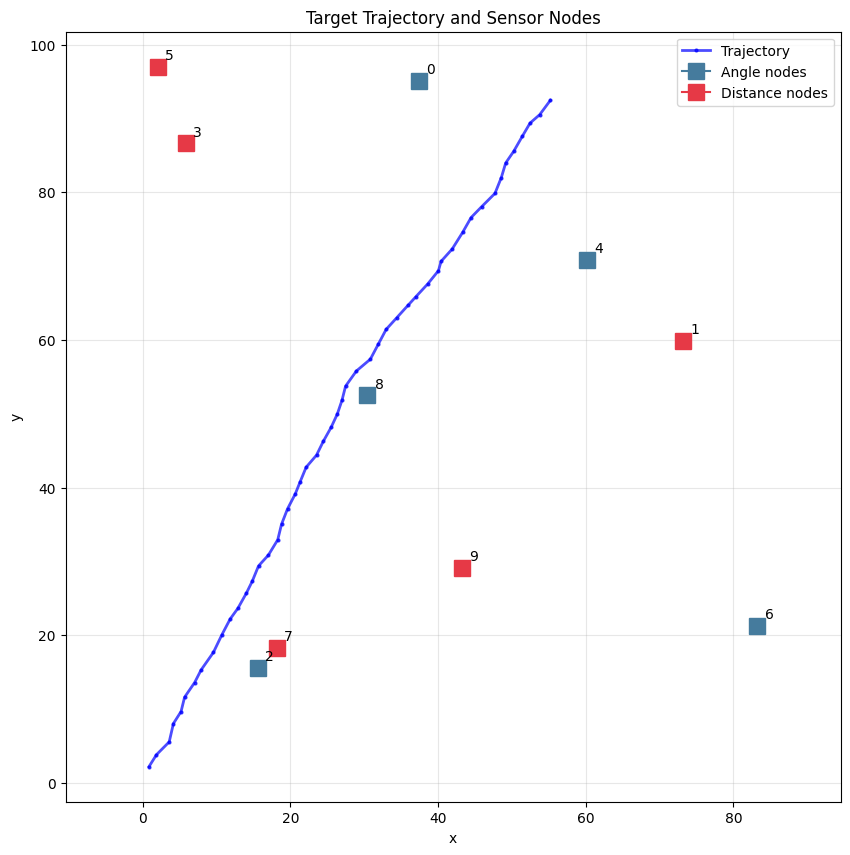

In [162]:
# Generate trajectory
trajectory = generate_trajectory(f_system, x_init, num_time_steps, process_noise_std)

# Generate measurements (shape: [num_nodes, batch=1, time_steps])
measurements = generate_measurements(h_system, trajectory, measurement_noise_std)

print(f"Trajectory shape: {trajectory.shape}")
print(f"Measurements shape: {measurements.shape} (num_nodes, batch, time_steps)")

# Plot trajectory and nodes
plot_trajectory_and_nodes(node_positions, node_types, trajectory)

### Create Graph

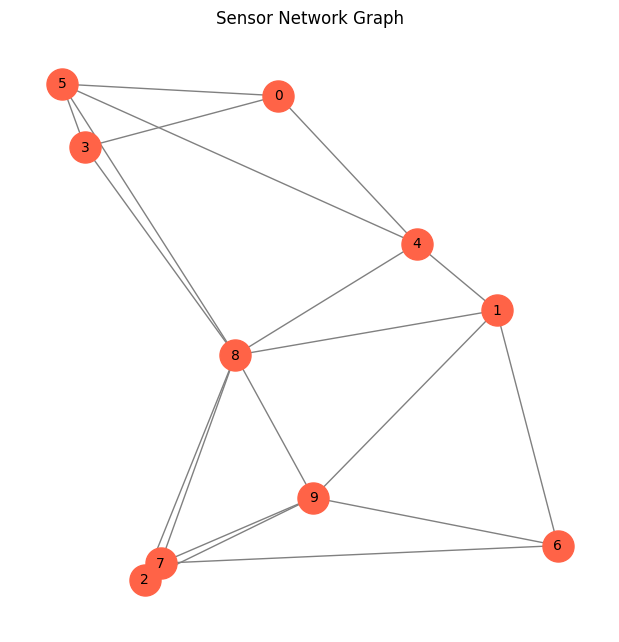

In [163]:
# Create distance-based graph
adjacency_matrix = create_distance_based_graph(node_positions, k_neighbors=3, seed=42)

# Plot the graph
plot_graph(adjacency_matrix, node_positions)

## 7. Run Kalman Filters

In [164]:
# Initial state estimate and covariance
state_dim = 4
x0_estimate = np.array([[0], [0], [0], [0]], dtype=float)
p0 = np.eye(state_dim) * 10  # High initial uncertainty

# Add self-loops to adjacency matrix for combination weights
j_matrix = adjacency_matrix + np.eye(num_nodes)

# Run Centralized EKF (from utils/ClassicDistributedKalman.py)
print("Running Centralized EKF...")
x_hat_cekf = centralized_extended_kalman_filter(
    measurements=measurements,
    f_system=f_system,
    h_system=h_system,
    r_array=r_array,
    q=process_noise_std,
    p0=p0,
    x0=x0_estimate,
    time_steps=num_time_steps,
    node_num=num_nodes
)
print("CEKF complete.")

Running Centralized EKF...
CEKF complete.


In [165]:
# Run Diffusion EKF (from utils/ClassicDistributedKalman.py)
print("Running Diffusion EKF...")
x_hat_dekf = diffusion_extended_kalman_filter_parallel_edge(
    measurements=measurements,
    f_system=f_system,
    h_system=h_system,
    r_array=r_array,
    q=process_noise_std,
    p0=p0,
    x0=x0_estimate,
    j_matrix=j_matrix,
    time_steps=num_time_steps,
    node_num=num_nodes
)
print("DEKF complete.")

Running Diffusion EKF...
DEKF complete.


## 8. Results

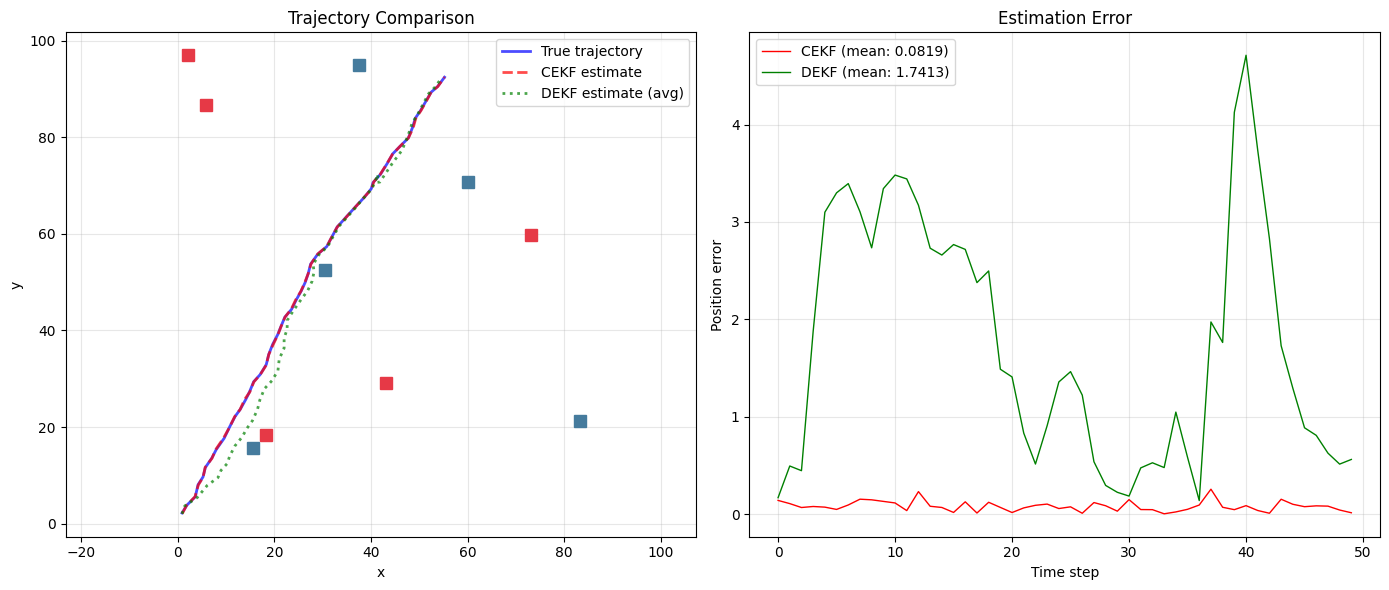


=== Results ===
CEKF - Mean error: 0.0819, Final error: 0.0152
DEKF - Mean error: 1.7413, Final error: 0.5624


In [166]:
# Plot results
plot_tracking_results(trajectory, x_hat_cekf, x_hat_dekf, node_positions, node_types)

# Compute and print errors
x_true = trajectory[:, 0, 0].numpy()
y_true = trajectory[:, 2, 0].numpy()

x_cekf = x_hat_cekf[:, 0, 0]
y_cekf = x_hat_cekf[:, 2, 0]
error_cekf = np.sqrt((x_true - x_cekf)**2 + (y_true - y_cekf)**2)

x_dekf = x_hat_dekf[:, :, 0, 0].mean(axis=1)
y_dekf = x_hat_dekf[:, :, 2, 0].mean(axis=1)
error_dekf = np.sqrt((x_true - x_dekf)**2 + (y_true - y_dekf)**2)

print("\n=== Results ===")
print(f"CEKF - Mean error: {error_cekf.mean():.4f}, Final error: {error_cekf[-1]:.4f}")
print(f"DEKF - Mean error: {error_dekf.mean():.4f}, Final error: {error_dekf[-1]:.4f}")

q=0.0: CEKF=0.0619, DEKF=3.6791
q=0.1: CEKF=0.0822, DEKF=2.2497
q=0.1: CEKF=0.0925, DEKF=1.5590
q=0.2: CEKF=0.0918, DEKF=2.5412
q=0.5: CEKF=0.0964, DEKF=6.6180
q=1.0: CEKF=0.1088, DEKF=8.2253
q=2.0: CEKF=0.1546, DEKF=7.0357
q=4.0: CEKF=0.3616, DEKF=19.8594


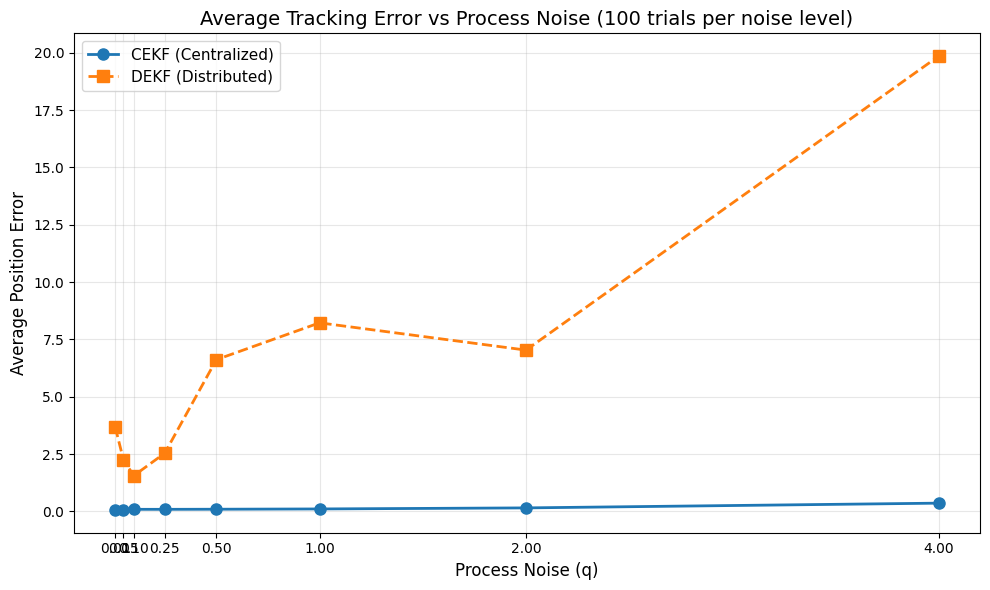

In [167]:
# Average Error vs Process Noise Study
# For each noise level, run multiple trials and compute mean position error

noise_values = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 4]
num_trials = 100

avg_error_dekf = []
avg_error_cekf = []

for q_noise in noise_values:
    trial_errors_dekf = []
    trial_errors_cekf = []
    
    for trial in range(num_trials):
        # Generate new trajectory and measurements for each trial
        traj = generate_trajectory(f_system, x_init, num_time_steps, q_noise)
        meas = generate_measurements(h_system, traj, measurement_noise_std)
        
        # Run DEKF
        x_hat_dekf = diffusion_extended_kalman_filter_parallel_edge(
            measurements=meas,
            f_system=f_system,
            h_system=h_system,
            r_array=r_array,
            q=q_noise,
            p0=p0,
            x0=x0_estimate,
            j_matrix=j_matrix,
            time_steps=num_time_steps,
            node_num=num_nodes
        )
        
        # Run CEKF
        x_hat_cekf = centralized_extended_kalman_filter(
            measurements=meas,
            f_system=f_system,
            h_system=h_system,
            r_array=r_array,
            q=q_noise,
            p0=p0,
            x0=x0_estimate,
            time_steps=num_time_steps,
            node_num=num_nodes
        )
        
        # Compute position errors
        x_true = traj[:, 0, 0].numpy()
        y_true = traj[:, 2, 0].numpy()
        
        # CEKF error (single estimate)
        x_cekf = x_hat_cekf[:, 0, 0]
        y_cekf = x_hat_cekf[:, 2, 0]
        error_cekf = np.sqrt((x_true - x_cekf)**2 + (y_true - y_cekf)**2).mean()
        
        # DEKF error (average across nodes)
        x_dekf = x_hat_dekf[:, :, 0, 0].mean(axis=1)
        y_dekf = x_hat_dekf[:, :, 2, 0].mean(axis=1)
        error_dekf = np.sqrt((x_true - x_dekf)**2 + (y_true - y_dekf)**2).mean()
        
        trial_errors_dekf.append(error_dekf)
        trial_errors_cekf.append(error_cekf)
    
    # Average error across all trials for this noise level
    avg_error_dekf.append(np.mean(trial_errors_dekf))
    avg_error_cekf.append(np.mean(trial_errors_cekf))
    print(f"q={q_noise:.1f}: CEKF={avg_error_cekf[-1]:.4f}, DEKF={avg_error_dekf[-1]:.4f}")

# Plot: Average Error vs Process Noise
plt.figure(figsize=(10, 6))
plt.plot(noise_values, avg_error_cekf, 'o-', linewidth=2, markersize=8, label='CEKF (Centralized)')
plt.plot(noise_values, avg_error_dekf, 's--', linewidth=2, markersize=8, label='DEKF (Distributed)')
plt.xlabel('Process Noise (q)', fontsize=12)
plt.ylabel('Average Position Error', fontsize=12)
plt.title(f'Average Tracking Error vs Process Noise ({num_trials} trials per noise level)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(noise_values)
plt.tight_layout()
plt.savefig('plots/average_error_vs_process_noise.png', dpi=300, bbox_inches='tight')
plt.show()


r=0.01: CEKF=0.0123, DEKF=3.2786
r=0.05: CEKF=0.0456, DEKF=1.6064
r=0.10: CEKF=0.0900, DEKF=1.5820
r=0.25: CEKF=0.2392, DEKF=2.5754
r=0.50: CEKF=0.5066, DEKF=2.4615
r=1.00: CEKF=1.1604, DEKF=3.2624
r=2.00: CEKF=2.7621, DEKF=4.1582
r=4.00: CEKF=6.7740, DEKF=7.9891


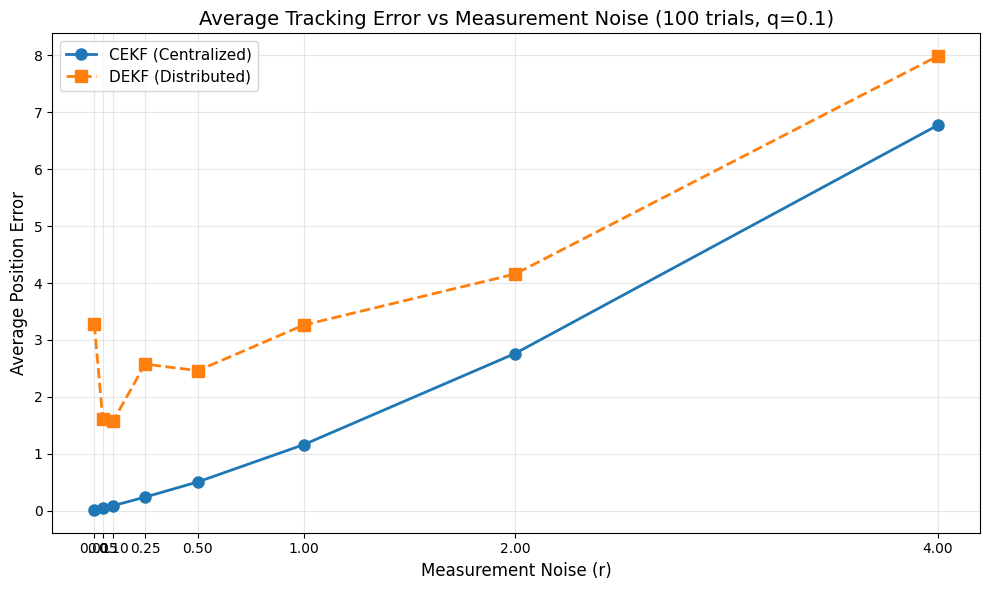

In [168]:
# Average Error vs Measurement Noise Study
# For each measurement noise level, run multiple trials and compute mean position error

measurement_noise_values = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 4]
num_trials = 100
q_fixed = 0.1  # Fixed process noise

avg_error_dekf_r = []
avg_error_cekf_r = []

for r_noise in measurement_noise_values:
    trial_errors_dekf = []
    trial_errors_cekf = []
    
    # Update r_array for this noise level
    r_array_test = r_noise * np.ones(num_nodes)
    
    for trial in range(num_trials):
        # Generate new trajectory with fixed process noise
        traj = generate_trajectory(f_system, x_init, num_time_steps, q_fixed)
        # Generate measurements with varying measurement noise
        meas = generate_measurements(h_system, traj, r_noise)
        
        # Run DEKF
        x_hat_dekf = diffusion_extended_kalman_filter_parallel_edge(
            measurements=meas,
            f_system=f_system,
            h_system=h_system,
            r_array=r_array_test,  # Use updated r_array
            q=q_fixed,
            p0=p0,
            x0=x0_estimate,
            j_matrix=j_matrix,
            time_steps=num_time_steps,
            node_num=num_nodes
        )
        
        # Run CEKF
        x_hat_cekf = centralized_extended_kalman_filter(
            measurements=meas,
            f_system=f_system,
            h_system=h_system,
            r_array=r_array_test,  # Use updated r_array
            q=q_fixed,
            p0=p0,
            x0=x0_estimate,
            time_steps=num_time_steps,
            node_num=num_nodes
        )
        
        # Compute position errors
        x_true = traj[:, 0, 0].numpy()
        y_true = traj[:, 2, 0].numpy()
        
        # CEKF error (single estimate)
        x_cekf = x_hat_cekf[:, 0, 0]
        y_cekf = x_hat_cekf[:, 2, 0]
        error_cekf = np.sqrt((x_true - x_cekf)**2 + (y_true - y_cekf)**2).mean()
        
        # DEKF error (average across nodes)
        x_dekf = x_hat_dekf[:, :, 0, 0].mean(axis=1)
        y_dekf = x_hat_dekf[:, :, 2, 0].mean(axis=1)
        error_dekf = np.sqrt((x_true - x_dekf)**2 + (y_true - y_dekf)**2).mean()
        
        trial_errors_dekf.append(error_dekf)
        trial_errors_cekf.append(error_cekf)
    
    # Average error across all trials for this noise level
    avg_error_dekf_r.append(np.mean(trial_errors_dekf))
    avg_error_cekf_r.append(np.mean(trial_errors_cekf))
    print(f"r={r_noise:.2f}: CEKF={avg_error_cekf_r[-1]:.4f}, DEKF={avg_error_dekf_r[-1]:.4f}")

# Plot: Average Error vs Measurement Noise
plt.figure(figsize=(10, 6))
plt.plot(measurement_noise_values, avg_error_cekf_r, 'o-', linewidth=2, markersize=8, label='CEKF (Centralized)')
plt.plot(measurement_noise_values, avg_error_dekf_r, 's--', linewidth=2, markersize=8, label='DEKF (Distributed)')
plt.xlabel('Measurement Noise (r)', fontsize=12)
plt.ylabel('Average Position Error', fontsize=12)
plt.title(f'Average Tracking Error vs Measurement Noise ({num_trials} trials, q={q_fixed})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(measurement_noise_values)
plt.tight_layout()
plt.savefig('plots/average_error_vs_measurement_noise.png', dpi=300, bbox_inches='tight')
plt.show()